> Note: use `qwen` env.

In [1]:
import os
import sys
import shutil
os.environ['TOKENIZERS_PARALLELISM'] = "False"

import torch
import numpy as np
import pandas as pd
import json
from torch.nn.functional import cosine_similarity
# from utils.video import read_frames_decord
from IPython.display import display, Markdown, Latex
import matplotlib.pyplot as plt

import shared.utils as su
# from notebooks.eval_care_retrieval import load_model

### `TVBench`

In [2]:
data_dir = "/scratch/shared/beegfs/piyush/datasets/TVBench"
video_dir = f"{data_dir}/video"
csv_path = f"{data_dir}/all_except_ntu120vids.csv"
assert os.path.exists(csv_path), f"CSV file not found: {csv_path}"
df = pd.read_csv(csv_path)
result_file = f"{su.log.repo_path}/results/tvbench_except_ntu120vids.npy"
assert os.path.exists(result_file)

# Load results
results = np.load(result_file, allow_pickle=True)
len(results), len(df)

(2405, 2405)

In [3]:
from utils.qwen3_utils import QwenWrapper

llm = QwenWrapper(model_name="/work/piyush/pretrained_checkpoints/Qwen3-4B-Instruct-2507")
llm.generate_answer('what is 42+3?')

Loading model /work/piyush/pretrained_checkpoints/Qwen3-4B-Instruct-2507........  



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.4 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/users/piyush/miniconda3/envs/qwen/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/users/piyush/miniconda3/envs/qwen/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/users/piyush/miniconda3/envs/qwen/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start
    self

AttributeError: _ARRAY_API not found

SystemError: <built-in function __import__> returned a result with an exception set

`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

::: Number of total parameters in Qwen3ForCausalLM: 4022.468M


{'thinking_content': '', 'content': '42 + 3 = 45.'}

**Test on a sample**

In [4]:
j = np.random.randint(len(results))
results[j]

{'video_file': 'action_count/video_7639.mp4',
 'video': 'video_7639.mp4',
 'video_path': '/scratch/shared/beegfs/piyush/datasets/TVBench/video/action_count/video_7639.mp4',
 'n_frames': 16,
 'question': 'How many containers did the person try to cover?',
 'options': ['2', '3', '5', '4'],
 'generated_answer': 'container',
 'indexed_options': ['0: 2', '1: 3', '2: 5', '3: 4'],
 'true_answer': '5'}

In [5]:
answer_true = results[j]['true_answer']
answer_genr = results[j]['generated_answer']

prompt = f"""
You are provided an answer generated by a model and the ground truth answer.
Your task is to judge how well the generated answer matches the ground truth.
Rate it on a scale of 0-10 where 0 is worst and 10 is best match.

Model prediction: {answer_genr}
Ground truth: {answer_true}

Only provide the rating number and no explanation.
"""

print(prompt)

llm.generate_answer(prompt)


You are provided an answer generated by a model and the ground truth answer.
Your task is to judge how well the generated answer matches the ground truth.
Rate it on a scale of 0-10 where 0 is worst and 10 is best match.

Model prediction: container
Ground truth: 5

Only provide the rating number and no explanation.



{'thinking_content': '', 'content': '0'}

In [6]:
iterator = su.log.tqdm_iterator(range(len(results)), desc='Evaluating answers')
judgements = []
for i in iterator:
    answer_true = results[i]['true_answer']
    answer_genr = results[i]['generated_answer']
    
    prompt = f"""
    You are provided an answer generated by a model and the ground truth answer.
    Your task is to judge how well the generated answer matches the ground truth.
    Rate it on a scale of 0-10 where 0 is worst and 10 is best match.
    
    Model prediction: {answer_genr}
    Ground truth: {answer_true}
    
    Only provide the rating number and no explanation.
    """
    judgement = llm.generate_answer(prompt)['content']
    judgements.append(judgement)
len(judgements)

Evaluating answers:   0%|          | 0/2405 [00:00<?, ?it/s]

2405

In [7]:
judgements = np.array(judgements).astype(int)
judgements.mean()

np.float64(2.9567567567567568)

In [63]:
np.mean(judgements > 5)

np.float64(0.21621621621621623)

In [71]:
judgement = 6
indices = np.where(judgements == judgement)[0]
print(f"Number of samples with judgement {judgement}: ", len(indices))
j = np.random.choice(indices)
results[j]

Number of samples with judgement 6:  31


{'video_file': 'egocentric_sequence/3.4/linxiaoyu.MP4',
 'video': '3.4/linxiaoyu.MP4',
 'video_path': '/scratch/shared/beegfs/piyush/datasets/TVBench/video/egocentric_sequence/3.4/linxiaoyu.MP4',
 'n_frames': 16,
 'question': 'What is the sequence of actions shown in the video?',
 'options': ['take up the dropper bottle, uncover the dropper bottle, squeeze the dropper, cover the dropper bottle with the dropper, put down the dropper bottle, take up the test tube, put down the test tube',
  'put down the test tube, squeeze the dropper, cover the dropper bottle with the dropper, uncover the dropper bottle, put down the dropper bottle, take up the dropper bottle, take up the test tube',
  'put down the test tube, squeeze the dropper, cover the dropper bottle with the dropper, uncover the dropper bottle, put down the dropper bottle, take up the test tube, take up the dropper bottle',
  'put down the test tube, uncover the dropper bottle, cover the dropper bottle with the dropper, squeeze th

In [72]:
correct = []
for r in results:
    a = r['true_answer'].strip().lower()
    b = r['generated_answer'].strip().lower()
    correct.append(a in b or b in a)
np.mean(correct)

np.float64(0.20623700623700625)

### NextQA

In [96]:
# Load NextQA dataset
data_dir = "/scratch/shared/beegfs/piyush/datasets/NExTQA"
csv_path = f"{data_dir}/mc.csv"
print(f"CSV file: {csv_path}")
video_dir = f"{data_dir}/NExTVideo"
assert os.path.exists(csv_path), f"CSV file not found: {csv_path}"
df = pd.read_csv(csv_path)

name = "tarsier7b-nextqa_mc.npy"
# name = "nextqa_mc.npy"
result_file = f"{su.log.repo_path}/results/{name}"

# Load results
results = np.load(result_file, allow_pickle=True)
len(results), len(df)

CSV file: /scratch/shared/beegfs/piyush/datasets/NExTQA/mc.csv


(7854, 8564)

In [97]:
j = np.random.randint(len(results))
results[j]

{'video': np.int64(3626207014),
 'video_path': '/scratch/shared/beegfs/piyush/datasets/NExTQA/NExTVideo/3626207014.mp4',
 'n_frames': 16,
 'question': 'why did the two children go under the man s legs?',
 'options': ['kissing the leg',
  'to pose for photo',
  'pick up toys',
  'kiss the ground',
  'play'],
 'generated_answer': 'Answer: 3: kiss the ground',
 'indexed_options': ['0: kissing the leg',
  '1: to pose for photo',
  '2: pick up toys',
  '3: kiss the ground',
  '4: play'],
 'true_answer': '4: play'}

In [98]:
answer_true = results[j]['true_answer']
answer_genr = results[j]['generated_answer']

prompt = f"""
You are provided an answer generated by a model and the ground truth answer.
Your task is to judge how well the generated answer matches the ground truth.
Rate it on a scale of 0-10 where 0 is worst and 10 is best match.

Model prediction: {answer_genr}
Ground truth: {answer_true}

Only provide the rating number and no explanation.
"""

print(prompt)

llm.generate_answer(prompt)


You are provided an answer generated by a model and the ground truth answer.
Your task is to judge how well the generated answer matches the ground truth.
Rate it on a scale of 0-10 where 0 is worst and 10 is best match.

Model prediction: Answer: 3: kiss the ground
Ground truth: 4: play

Only provide the rating number and no explanation.



{'thinking_content': '', 'content': '0'}

In [106]:
iterator = su.log.tqdm_iterator(range(len(results)), desc='Evaluating answers')
judgements = []
for i in iterator:
    answer_true = results[i]['true_answer']
    answer_genr = results[i]['generated_answer']
    
    prompt = f"""
    You are provided an answer generated by a model and the ground truth answer.
    Your task is to judge how well the generated answer matches the ground truth.
    Rate it on a scale of 0-10 where 0 is worst and 10 is best match.
    
    Model prediction: '{answer_genr}'
    Ground truth: '{answer_true}'
    
    Only provide the rating number and no explanation.
    """
    judgement = llm.generate_answer(prompt)['content']
    judgements.append(judgement)
len(judgements)

Evaluating answers:   0%|          | 0/7854 [00:00<?, ?it/s]

7854

In [107]:
np.array(judgements).astype(int)

array([10, 10,  0, ...,  0,  0, 10], shape=(7854,))

In [108]:
judgements = np.array(judgements).astype(int)
judgements.mean()

np.float64(6.767125031830914)

In [110]:
(judgements > 5).mean()

np.float64(0.6159918512859689)

(array([1.126e+03, 0.000e+00, 1.400e+01, 0.000e+00, 1.054e+03, 0.000e+00,
        3.000e+01, 0.000e+00, 3.000e+00, 0.000e+00, 4.290e+02, 0.000e+00,
        5.000e+00, 0.000e+00, 1.700e+01, 0.000e+00, 5.400e+01, 0.000e+00,
        7.200e+01, 4.096e+03]),
 array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
         5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. ]),
 <BarContainer object of 20 artists>)

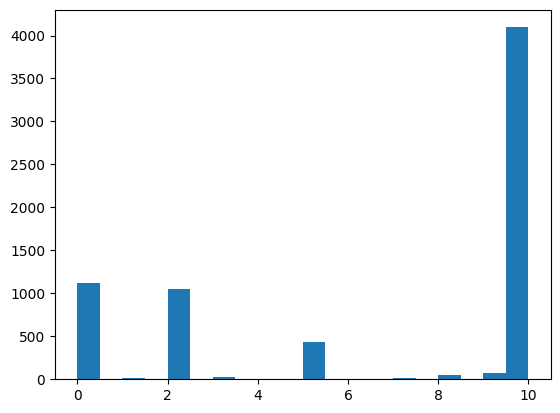

In [81]:
plt.hist(judgements, bins=20)

In [90]:
indices = np.where(judgements == 3)[0]
j = np.random.choice(indices)
results[j]

{'video': np.int64(4242382178),
 'video_path': '/scratch/shared/beegfs/piyush/datasets/NExTQA/NExTVideo/4242382178.mp4',
 'n_frames': 16,
 'question': 'why does the lady in green starts clapping near the end?',
 'options': ['acting',
  'present something',
  'dance routine',
  'following rhythm',
  'emphasise point'],
 'generated_answer': 'The video shows that the lady in green starts clapping near the end because she is following a rhythm set by the music.',
 'indexed_options': ['0: acting',
  '1: present something',
  '2: dance routine',
  '3: following rhythm',
  '4: emphasise point'],
 'true_answer': '3: following rhythm'}

In [92]:
r = results[j]

generated_answers = []
for r in results:
    generated_answers.append(r['generated_answer'].split(":")[-1].strip())
len(generated_answers)

6900

In [93]:
r['true_answer'].split(':')[1].strip()

'toy'

In [94]:
actual_answers = [r['true_answer'].split(':')[1].strip() for r in results]
len(actual_answers)

6900

In [95]:
np.mean(
    np.array(actual_answers) == np.array(generated_answers)
)

np.float64(0.603768115942029)